# Causal Impact

## 1. Concepts

The <a href=https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf>Causal Impact</a> model developed by Google works by fitting a bayesian structural time series model to observed data which is later used for predicting what the results would be had no intervention happened in a given time period, as depicted below:

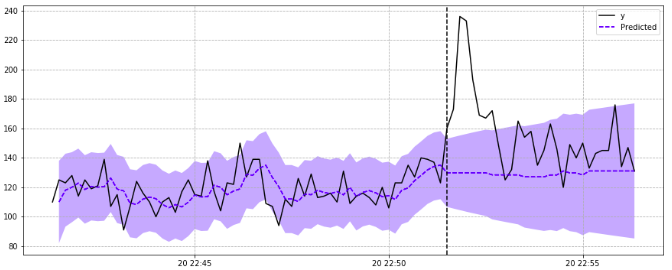

The idea is to used the predictions of the fitted model (depicted in blue) as a reference to what probably would had been observed with no intervention taking place.

Bayesian Structural Time Series models can be expressed by the following equations:

<center>$ y_t = Z^T_t\alpha_t + \beta X_t + G_t\epsilon_t$</center>
<center>$ a_{t+1} = T_t\alpha_t + H_t\eta_t$</center>
<center>$\epsilon_t \sim \mathcal{N}(0, \sigma_t^2)$</center>
<center>$\eta_t \sim \mathcal{N}(0, Q_t)$</center>

The $a$ is also referred as a "state" of the series and $y_t$ is a linear combination of the states plus a linear regression with the covariates $X$ (and the measurement noise $\epsilon$ that follows a zero-mean normal distribution).

By varying the matricex $Z$, $T$, $G$ and $H$ we can model several distinct behaviors for the time series (including the more well known such as ARMA or ARIMA).

In this package (the same is true for Google's R package), you can choose any time series model you want to fit your data (more about this later below). If no model is used as input, a local level is built by default, which means $y_t$ is expressed as:

<center>$ y_t = \mu_t + \beta X_t + \epsilon_t$</center>
<center>$ \mu_{t+1} = \mu_t +  \eta_{\mu, t}$</center>

One important aspect of the model that should be noted carefully is that the linear regression $\beta X_t$ is the core component that explains $y_t$. The local level component ($\mu_t$) is merely a random walk value which, therefore, doesn't explain anything of the observed data (as it tries to model it with randomness) so the assumption here is that we can model our observed data with the covariates and for scenarios where it's not true, the value of $\eta_{\mu, t}$ grows as to add uncertainty when making predictions.

## 2. How to Use

### 2.1 Generating Sample Data

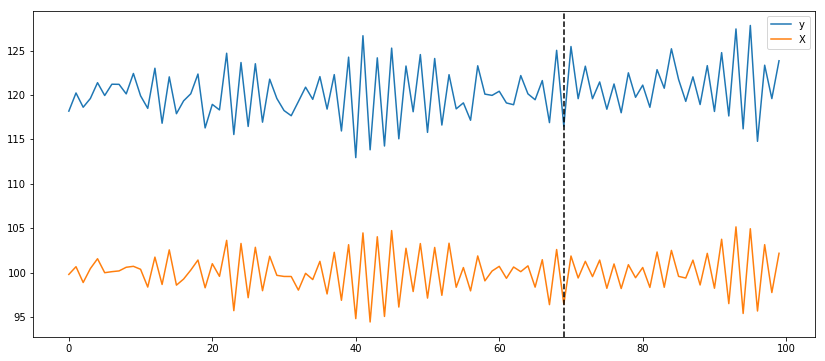

In [7]:
# This is an example presented in Google's R code.
np.random.seed(12345)
ar = np.r_[1, 0.9]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

X = 100 + arma_process.generate_sample(nsample=100)
y = 1.2 * X + np.random.normal(size=100)
y[70:] += 1
data = pd.DataFrame({'X': X, 'y': y}, columns=['y', 'X'])

data.plot()
plt.axvline(69, linestyle='--', color='k')
plt.legend();

### 2.1 Using Default Model

In [8]:
from causalimpact import CausalImpact


pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)

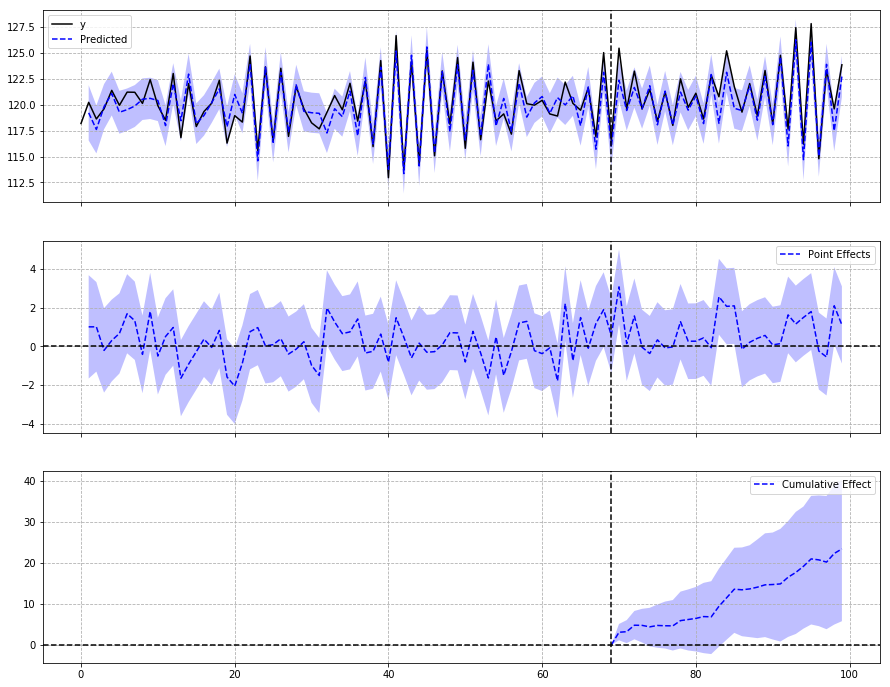

In [9]:
ci.plot(figsize=(15, 12))

When plotting results three graphics are printed by default: the origial series versus its predicted, the points effects (which is the difference between original series and the predicted one) and finally the cumulative effect which is basically the summation of the point effects accumulated over time.

You can choose which are printed though, here's an example of just the original series and its point-wise effect printed out:

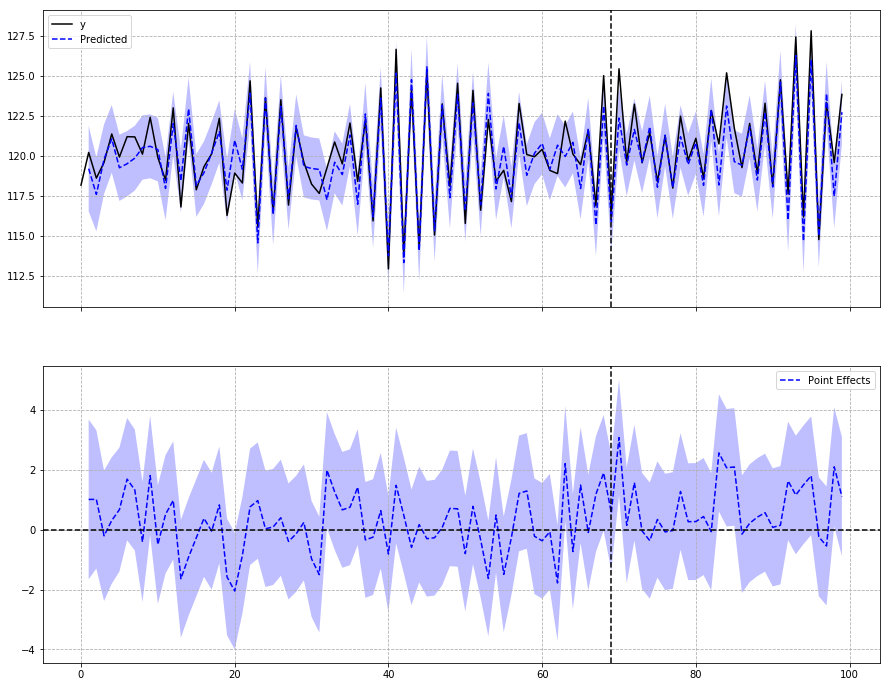

In [10]:
ci.plot(panels=['original', 'pointwise'], figsize=(15, 12))

For also viewing general results and numbers, you can invoke the `summary` method with either default input or "report" which prints a more detailed explanation of the observed effects:

In [11]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    121.2              3636.9
Prediction (s.d.)         120.4 (0.3)        3613.5 (8.8)
95% CI                    [119.9, 121.0]     [3596.6, 3631.1]

Absolute effect (s.d.)    0.8 (0.3)          23.4 (8.8)
95% CI                    [0.2, 1.3]         [5.8, 40.3]

Relative effect (s.d.)    0.6% (0.2%)        0.6% (0.2%)
95% CI                    [0.2%, 1.1%]       [0.2%, 1.1%]

Posterior tail-area probability p: 0.005
Posterior prob. of a causal effect: 99.50%

For more details run the command: print(impact.summary('report'))


We can see here for instance that the absolute effect observed is of 0.8 whose predictions varies from -1.2 up to 2.7 with 95% confidence (notice it's quite close. It won't be exact given we have added noise to data).

A very important number to also consider when observing these results is the `p-value` or the probability of having a causal effect indeed (and not just noise). Remember to use this value in your analysis before taking conclusions.

If you want a more detailed summary, run the following:

In [12]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 121.2. By contrast, in the absence of an
intervention, we would have expected an average response of 120.4.
The 95% CI interval of this counterfactual prediction is [119.9, 121.0].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.8 with a 95% CI interval of
[0.2, 1.3]. For a discussion of the significance of this effect,
see below.

Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3636.9.
By contrast, had the intervention not taken place, we would have expected
a sum of 3613.5. The 95% CI interval of this prediction is [3596.6, 3631.1].

The above results are given in terms of absolute numbers. In relative
terms, the response varia

The `ci` object also carries all the results of the fitting process, you can access all these values if you want to further analyze results:

In [13]:
ci.inferences.head()

,post_cum_y,preds,post_preds,post_preds_lower,post_preds_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effects,point_effects_lower,point_effects_upper,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
0,NaN,119.729458,NaN,NaN,NaN,-5712.599529,5952.058445,NaN,NaN,NaN,-1.540765,-5833.869752,5830.788222,NaN,NaN,NaN
1,NaN,119.219896,NaN,NaN,NaN,116.548485,121.891306,NaN,NaN,NaN,1.013380,-1.658030,3.684791,NaN,NaN,NaN
2,NaN,117.612838,NaN,NaN,NaN,115.298438,119.927238,NaN,NaN,NaN,1.014937,-1.299463,3.329337,NaN,NaN,NaN
3,NaN,119.812232,NaN,NaN,NaN,117.629357,121.995108,NaN,NaN,NaN,-0.202510,-2.385385,1.980366,NaN,NaN,NaN
4,NaN,121.083389,NaN,NaN,NaN,118.969019,123.197758,NaN,NaN,NaN,0.308120,-1.806250,2.422489,NaN,NaN,NaN


You can also retrieve information related to the trained model (such as what were the fitted parameters and so on):

In [14]:
ci.trained_model.params

sigma2.irregular    0.104777
sigma2.level        0.000243
beta.X              0.947841
dtype: float64

### 2.2 Working with Dates Index

The model should work with dates as well. Let's see what happens when our input data have a date as index type:

In [15]:
dated_data = data.set_index(pd.date_range(start='20180101', periods=len(data)))

pre_period = ['20180101', '20180311']
post_period = ['20180312', '20180410']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

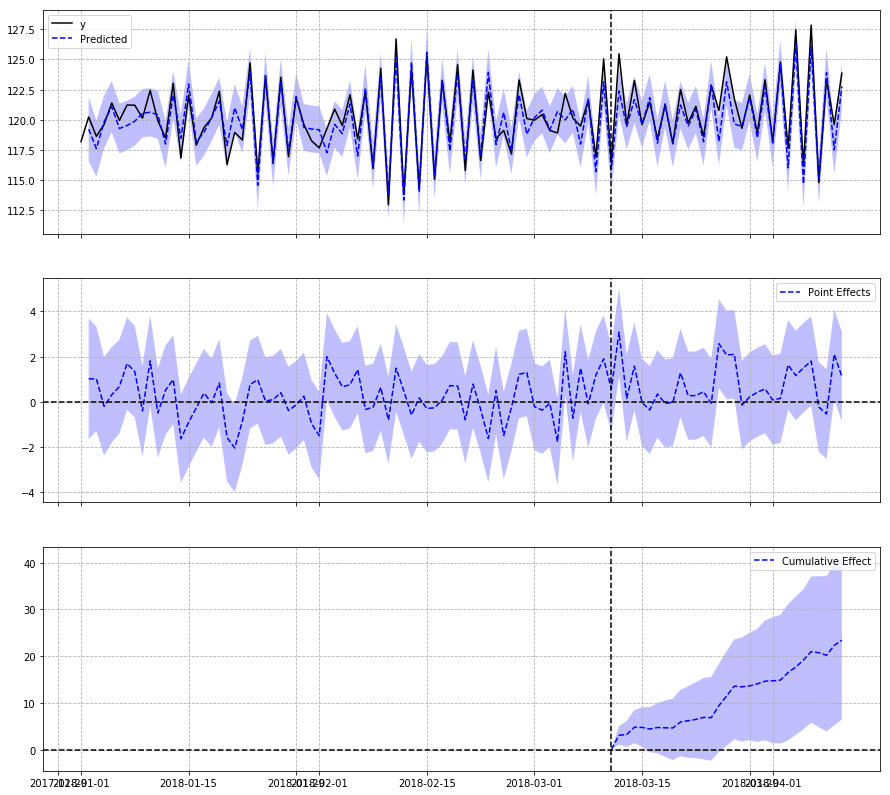

In [16]:
ci.plot(figsize=(15, 14))

In [17]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    121.2              3636.9
Prediction (s.d.)         120.4 (0.3)        3613.5 (8.9)
95% CI                    [119.9, 121.0]     [3595.7, 3630.4]

Absolute effect (s.d.)    0.8 (0.3)          23.4 (8.9)
95% CI                    [0.2, 1.4]         [6.4, 41.2]

Relative effect (s.d.)    0.6% (0.2%)        0.6% (0.2%)
95% CI                    [0.2%, 1.1%]       [0.2%, 1.1%]

Posterior tail-area probability p: 0.008
Posterior prob. of a causal effect: 99.20%

For more details run the command: print(impact.summary('report'))


### 2.3 Customized Model

Just as in Google R package, here you can also choose a customized model to be trained in the pre-intervention period. It's important to note that if you want to have the data standardized, then your customized model must be built with data already standardized and the input `data` must be the original denormalized data, like so:

In [36]:
from causalimpact.misc import standardize

normed_pre_data, _ = standardize(data.iloc[:70])

model = UnobservedComponents(
    endog=normed_pre_data.iloc[:70, 0],
    level='llevel',
    exog=normed_pre_data.iloc[:70, 1:]
)

pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period, model=model)

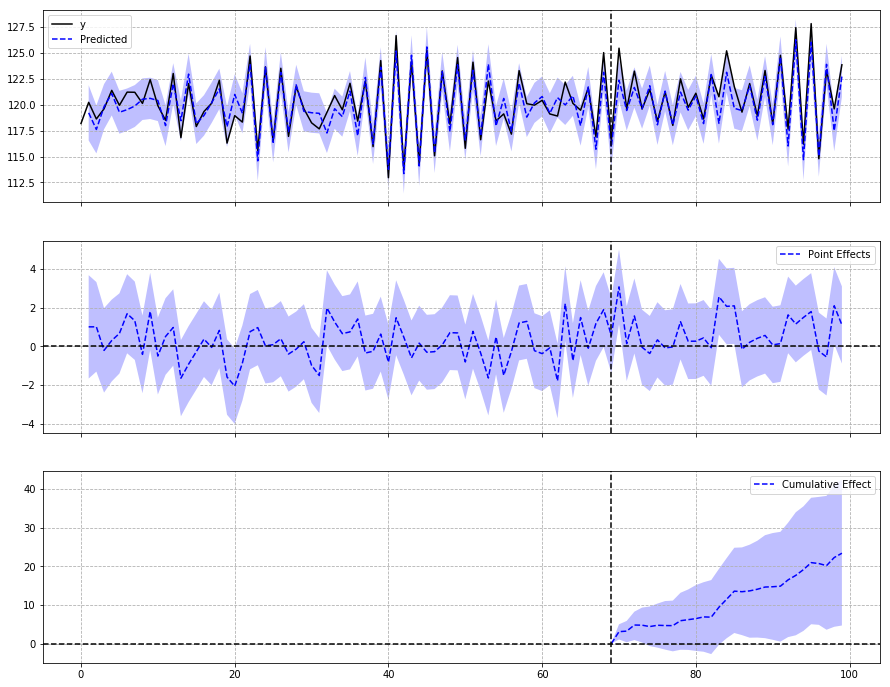

In [37]:
ci.plot(figsize=(15, 12))

In [38]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    121.2              3636.9
Prediction (s.d.)         120.4 (0.3)        3613.5 (9.6)
95% CI                    [119.8, 121.1]     [3594.4, 3632.2]

Absolute effect (s.d.)    0.8 (0.3)          23.4 (9.6)
95% CI                    [0.2, 1.4]         [4.7, 42.5]

Relative effect (s.d.)    0.6% (0.3%)        0.6% (0.3%)
95% CI                    [0.1%, 1.2%]       [0.1%, 1.2%]

Posterior tail-area probability p: 0.008
Posterior prob. of a causal effect: 99.20%

For more details run the command: print(impact.summary('report'))


In [21]:
ci.trained_model.params

sigma2.irregular    0.104777
sigma2.level        0.000243
beta.X              0.947841
dtype: float64

### 2.5 Understanding Results

While this is a more sophisticated approach into understanding results from the model, you can print out metrics of the trained model to see why it has fitted the way it has:

In [24]:
dated_data = data.set_index(pd.date_range(start='20180101', periods=len(data)))

pre_period = ['20180101', '20180311']
post_period = ['20180312', '20180410']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

Remember that the local level model is built by using a noise $\epsilon$, a random walk (level) and the linear regression (beta.X). Sometimes you'll want to see what the values for beta.X are: in case it's too big, then probably the covariate you used in your model is not helping much to explain $y_t$ and you probably can get rid of it.

In [25]:
ci.trained_model.params

sigma2.irregular    0.104777
sigma2.level        0.000243
beta.X              0.947841
dtype: float64

As we can see, the beta.X helps to explain a lot of what is observed in the response variable. Let's see what happens when we add a total random variable as a covariate to our data:

In [26]:
x2 = pd.DataFrame(np.random.randn(100, 1), columns=['x2'])
data2 = pd.concat([data, x2], axis=1)

In [27]:
pre_period = [0, 69]
post_period = [70, 99]
ci = CausalImpact(data2, pre_period, post_period)

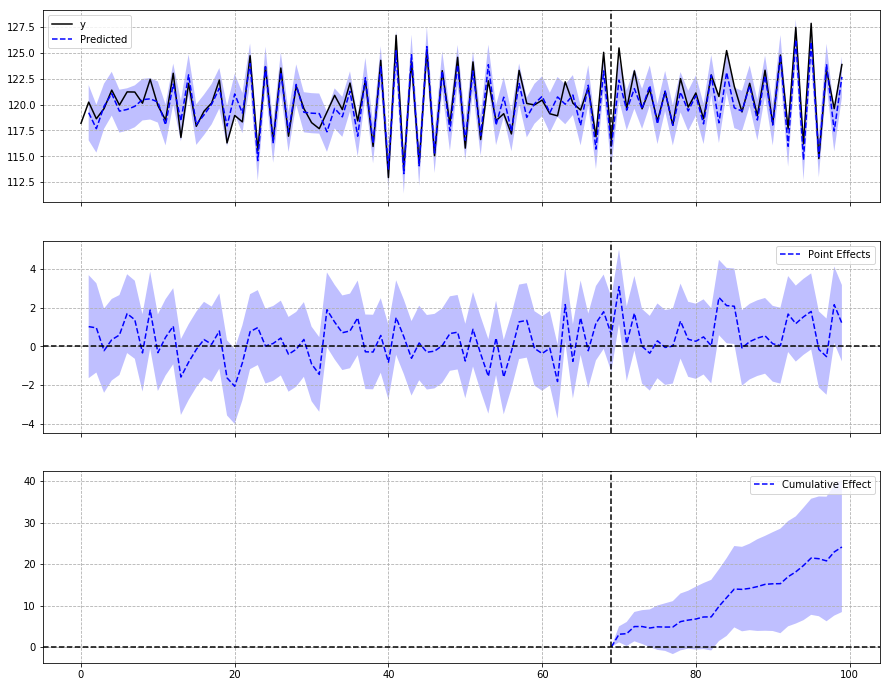

In [28]:
ci.plot(figsize=(15, 12))

In [29]:
ci.trained_model.params

sigma2.irregular    0.104709
sigma2.level        0.000201
beta.X              0.946782
beta.x2            -0.020056
dtype: float64

You will find cases where the covariates don't precisely explain the response variable. Here's an example:

In [30]:
gdata = pd.read_csv('../tests/fixtures/google_data.csv')
gdata.index = pd.to_datetime(gdata['t'])
del gdata['t']

In [31]:
pre_period = ['2016-02-20 22:41:20', '2016-02-20 22:51:20']
post_period = ['2016-02-20 22:51:30', '2016-02-20 22:56:20']

ci = CausalImpact(gdata, pre_period, post_period)

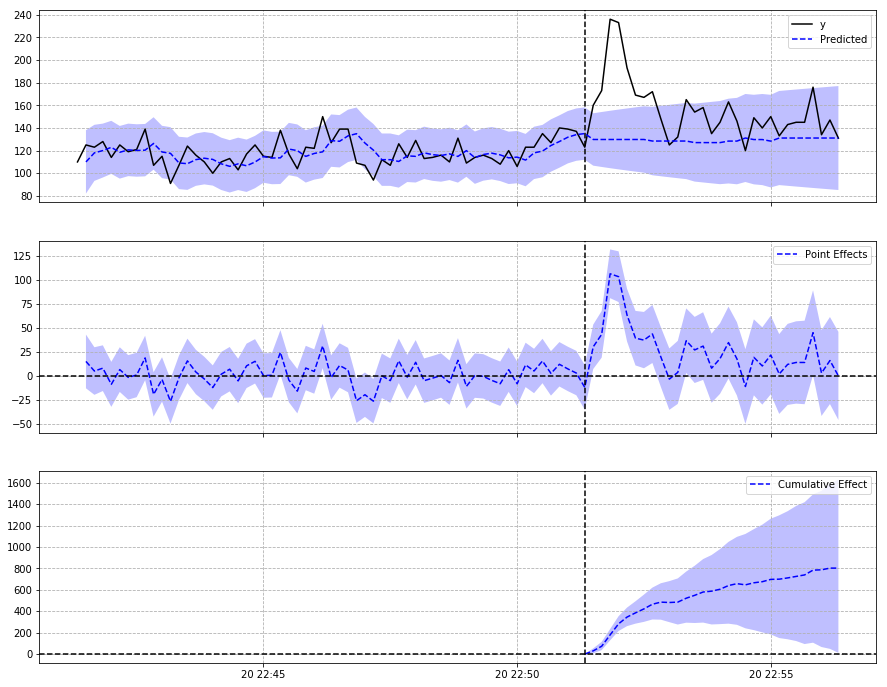

In [32]:
ci.plot(figsize=(15, 12))

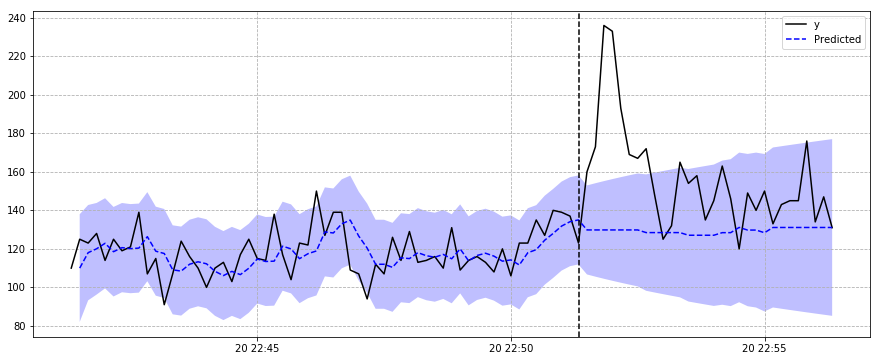

In [33]:
ci.plot(figsize=(15, 6), panels=['original'])

In [34]:
ci.trained_model.params

sigma2.irregular    0.667721
sigma2.level        0.099363
beta.x1             0.405504
beta.x2            -0.353929
dtype: float64

In [35]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    156.2              4687.0
Prediction (s.d.)         129.5 (13.8)       3883.9 (412.8)
95% CI                    [101.9, 155.8]     [3057.3, 4675.3]

Absolute effect (s.d.)    26.8 (13.8)        803.1 (412.8)
95% CI                    [0.4, 54.3]        [11.7, 1629.7]

Relative effect (s.d.)    20.7% (10.6%)      20.7% (10.6%)
95% CI                    [0.3%, 42.0%]      [0.3%, 42.0%]

Posterior tail-area probability p: 0.024
Posterior prob. of a causal effect: 97.60%

For more details run the command: print(impact.summary('report'))


Notice the widening of the confidence intervals in the post-intervention period. This increase in upper and lower boundaries is due the random walk component that models uncertainty not well explained by the covariates.

### 2.6 TODO's

- We still need to implement seasons by default (currently only by the customized model one can make use of it).
- Still need to investigate how useful computing the bayesian regret it would be for final summary.

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
figsize(14, 6)

In [2]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()